# Introducción

El trabajo de un profesor es un trabajo difícil, pues son los encargados de que el día de mañana sus pequeños aprendices sean personas que puedan aportar a la sociedad con su conocimiento y trabajo, pero al mismo tiempo también acaban teniendo un trabajo en valores debido a la gran cantidad de horas que conviven con sus pupilos.

Es por todo esto que la etapa escolar es bastante definitoria, y aunque haya opiniones diversas, al final esta etapa se superará y quedará marcada por el rendimiento que tenga el alumno en ella. Esto vuelve aún más complejo el trabajo de un profesor, pues debe ser capaz de hacer que sus alumnos tengan un buen rendimiento teniendo en cuenta que cada uno es distinto, y que cada uno tiene unas situaciones particulares. Ya no es algo solamente lógico, sino que también se ha notado que en muchas ocasiones los profesores no son capaces de prestar atención a aquel que más lo necesita, para poner especial empeño y adaptaciones para que este consiga el éxito en la etapa escolar.

Este estudio trata de echar una mano a estos profesores que no saben identificar a tiempo a aquellos alumnos que van a acabar necesitando más ayuda. Vamos a realizar un análisis de datos de una encuesta realizada en Bangladesh a ciertos alumnos. Esta encuesta contiene ciertos valores que nos parecen interesantes de revisar ya que pensamos que afectan o acabarán afectando al rendimiento escolar de un alumno

# Dataset

## Columnas del dataset que vamos a usar
- `Gender`: Género del alumno
- `Age` : Edad del alumno
- `Study Hour/Day` : Horas de estudio al día
- `Learning mode` : Modalidad de aprendizaje
- `How many hour do you spent daily in social media?` : Horas diarias en redes sociales
- `Average attendance` : Asistencia media
- `With whom you are living?` : Con quién vive
- `What was your previous SGPA?` : Nota media anterior
- `What is your monthly family income?` : Ingresos familiares

Lo primero que hemos hecho ha sido renombrar algunas de las columnas ya que no estaban muy bien redactadas. Además, hemos eliminado las columnas que no vamos a utilizar en nuestro análisis. 

Lo siguiente que hemos hecho ha sido eliminar las filas que contienen valores nulos.

In [1]:
#Limpieza del dataset de los datos de los estudiantes.
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
import regex as re

#Cargamos el dataset

data = pd.read_csv('Students_Performance_data_set.csv')

pd.set_option('display.max_columns', None)

data.shape

#Renombramos las columnas que nos interesan

new_columns = {'Gender':'Gender', 'Age':'Age', 'Study Hour/day':'Study time', 'Learning mode':'Learning mode', 'How many hour do you spent daily in social media?':'Time on social media', 'Average attendance on class':'Average attendance', 'With whom you are living with?':'Cohabitants', 'What was your previous SGPA?':'Previous SGPA', 'What is your current CGPA?':'Current CPGA', 'What is your monthly family income?':'Family income'}

data.rename(columns=new_columns, inplace=True)

#Seleccionamos las columnas que nos interesan

columns_of_interest = ['Gender', 'Age', 'Study time', 'Learning mode', 'Time on social media', 'Average attendance', 'Cohabitants', 'Previous SGPA', 'Current CPGA',  'Family income']

data = data[columns_of_interest]

#Eliminamos las filas con valores nulos
data = data.dropna()

## Estandarización de Age
Hemos usado la funcion unique() para ver que tipos de valores pueden tomar estos datos. Hemos apuntados aquellos que no son numéricos o dan un rango y hemos decidido cambiarlos a numéricos. Esto se puede ver el bloque de código siguiente.

In [2]:
data['Age'].unique()

# notamos que hay 6 valores que se salen de un numero como tal asi que usamos un replace para cambiarlos a un valor que no afecte el analisis
data['Age'] = data['Age'].replace({
    '21+' : 21,
    '23.6' : 23,
    '20+' : 20,
    '22+' : 22,
    '24+' : 24,
    '20 years 6 months' : 20
})

## Estandarizacion de tiempos

Lo que hemos hecho en el codigo que sigue este bloque de markdown es estandarizar los tiempos para poder tener los datos correctos tanto como para el Study Time como para el Time on Social Media.

In [3]:
### Usamos la función unique para ver los valores únicos de la columna y asi saber como estandarizarlos
# print(data['Study time'].unique())

def standarise_time(time): # sigue teniendo un error en la función cuando tiene un valor de minutos y otro seguido de horas
    # we extract the number and hour/minute from the string
    hours_numeric = re.findall(r'\d+', str(time))
    
    # extract the numeric value for the hours
    if 'hours' in str(time).lower() or 'hour' in str(time).lower() or 'hrs' in str(time).lower() or 'hr' in str(time).lower():
        if hours_numeric:
            return int(hours_numeric[0])
        else:
            return None
    # extract the numeric value for the minutes and convert them to hours convert to lower case to avoid case sensitivity
    elif 'minutes' in str(time).lower() or 'minute' in str(time).lower() or 'mins' in str(time).lower() or 'min' in str(time).lower() :
        if hours_numeric:
            return int(hours_numeric[0])/60
        else:
            return None

    # Some of the data is written in a range format, so we need to calculate the average
    elif '-' in str(time) or 'to' in str(time).lower() or 'or' in str(time).lower() or '/' in str(time):
        # we calculate the average
        if len(hours_numeric) == 2:
            return (int(hours_numeric[0]) + int(hours_numeric[1]))/2
        else:
            return None
    # if the data is in a numeric format, we just return the number
    elif hours_numeric:
        return int(hours_numeric[0])
    else:
        return None

# Aplicamos la función a la columna "Study time"
data['Study stand'] = data['Study time'].apply(standarise_time)

# Aplicamos la función a la columna "Time on social media"
data['Social stand'] = data['Time on social media'].apply(standarise_time)

## Estandarizacion de Attendance

En el siguiente bloque de codigo hemos implementado la funcion standarise_attendance(value) convirtiendo los datos para que siguan el mismo formato compuesto por un numero y ya esta. Para aquellos valores que sean NaN, cogeremos el valor medio de la columna. 

In [4]:
def standarise_attendance(attendance):
    
    # primero quitamos todos los caracteres que no sean alfanuméricos o un signo de porcentaje
    value = re.sub(r'[^a-zA-Z0-9%]', '', str(attendance))
    
    if '%' in value:
        value = re.search(r'\d+', value).group()
        value = int(value)
    # si no es un porcentaje intentar convertirlo a un número
    else:
        try:
            value = int(value)
        except ValueError:
            value = float('nan')
            
    # asegurarse de que el valor esté entre 0 y 100
    value = min(max(value, 0), 100)
    return value

## Aplicamos la función a la columna "Average attendance"
data['Attendance stand'] = data['Average attendance'].apply(standarise_attendance)

## Estandarizacion de CGPA y SGPA

En este caso en vez de definir una funcion como todos los datos que estan en formato numerico son correctos usamos to_numeric() de pandas, cuando se encuentre con una valor que no se puede convertir a numerico devolvemos NaN con errors='coerce'.

In [5]:
data["Current CPGA stand"] = pd.to_numeric(data["Current CPGA"], errors='coerce')

data["Previous SGPA stand"] = pd.to_numeric(data["Previous SGPA"], errors='coerce')

## Estandandarizacion de Family Income
Como siempre usamos data.unique() para ver los valores que toman los datos y de ahi decidir como vamos a tratar los datos que consideramos "anomalos" o mal escritos.

1. Convertir de otras monedas y otras magnitudes a bdt 10E
2. Transformar los rangos a un valor numerico
3. Quitar el BDT que es la moneda de Bangladesh
4. Dejar numeros limpios. Alguna gente a puesto valores como "Approximately 30000". Lo hemos convertido al valor numerico

In [6]:

# transform currency to bdt 10E
def convert_to_bdt_standard(income):
    if isinstance(income, str) and '$' in income.lower():
        number = re.findall(r'\d+', income)
        if number:
            return int(number[0])*109.7 #Conversion de dolar a taka 10.04.2024
    if isinstance(income, str) and 'lac' in income.lower():
        number = re.findall(r'\d+', income)
        if number:
            return int(number[0])*100000 #Conversion de lakh(lac) a estandard
    if isinstance(income, str) and 'k' in income.lower():
        number = re.findall(r'\d+', income)
        if number:
            return int(number[0])*1000
    return income

# transformamos rangos a la media
def remove_range(income):
    if isinstance(income, str) and ('-' in income or '/' in income) :
        numbers = re.findall(r'\d+', income)
        if len(numbers) == 2:
            return (int(numbers[0]) + int(numbers[1]))/2
    return income
    
# quitando el BDT
def remove_BDT(income):
    if isinstance(income, str) and ('bdt' in income.lower() or 'DBT' in income or 'BTD' in income or 'taka' in income):
        number = re.findall(r'\d+', income)
        if number:
            return int(number[0])
    return income

def clean_numbers(income):
    if isinstance(income, str):
        number = re.findall(r'\d+', income)
        if number:
            return number[0]
    return income

# apply the function to the column
data['Family income stand'] = data['Family income'].apply(convert_to_bdt_standard)
data['Family income stand'] = data['Family income stand'].apply(remove_range)
data['Family income stand'] = data['Family income stand'].apply(remove_BDT)
data['Family income stand'] = data['Family income stand'].apply(clean_numbers)
data['Family income stand'] = pd.to_numeric(data['Family income stand'], errors='coerce')

## Conversion de datos

Convertimos los numeros a numericos

In [7]:
data['Family income stand'] = pd.to_numeric(data['Family income stand'], errors='coerce')
data['Attendance stand'] = pd.to_numeric(data['Attendance stand'], errors='coerce')
data['Study stand'] = pd.to_numeric(data['Study stand'], errors='coerce')
data['Social stand'] = pd.to_numeric(data['Social stand'], errors='coerce')
data['Age stand'] = pd.to_numeric(data['Age'], errors='coerce')

## creamos un nuevo dataset con las columnas que nos interesan
new_columns = ['Gender', 'Age stand', 'Study stand', 'Learning mode', 'Social stand', 'Attendance stand', 'Cohabitants', 'Previous SGPA stand', 'Current CPGA stand', 'Family income stand']

data = data[new_columns]

## data.dropna()
display(data)

## mostrar numero de valores nulos
print(data.isnull().sum())

data.to_csv('Students_Performance_data_set_cleaned.csv', index=False)
dataCL = pd.read_csv('Students_Performance_data_set_cleaned.csv')

,Gender,Age stand,Study stand,Learning mode,Social stand,Attendance stand,Cohabitants,Previous SGPA stand,Current CPGA stand,Family income stand
7,Female,22,2.0,Offline,2.0,100.0,Bachelor,3.80,3.64,32500.0
11,Male,22,3.0,Offline,2.0,90.0,Bachelor,3.40,3.53,20000.0
15,Male,20,2.0,Offline,1.0,95.0,Family,3.93,3.89,30000.0
18,Male,21,1.0,Online,3.0,NaN,Family,3.10,3.50,NaN
20,Female,21,3.0,Offline,2.0,96.0,Bachelor,3.81,3.65,30000.0
...,...,...,...,...,...,...,...,...,...,...
1189,Female,20,1.0,Online,2.0,46.0,Bachelor,2.65,3.77,180000.0
1190,Male,23,4.0,Offline,4.0,100.0,Bachelor,2.50,2.22,200000.0
1191,Male,22,3.0,Offline,2.0,100.0,Family,1.56,2.78,200000.0
1192,Female,25,5.0,Offline,3.0,100.0,Bachelor,1.40,2.52,210000.0


Gender                  0
Age stand               0
Study stand            99
Learning mode           0
Social stand           89
Attendance stand       22
Cohabitants             0
Previous SGPA stand    37
Current CPGA stand     60
Family income stand    26
dtype: int64


## Preparación datos para entrenamieto
Utilizamos preprocessing y KNNImputer para transformar los datos cualitativos a valores discretos que el algoritmo entienda y podamos realizar imputaciones con ellos.

1. Codificamos las columnas de género, modo de aprendizaje y convivientes a valores discretos.
2. Creamos nuestro imputador para que utilize los 5 vecinos más cercanos y rellenamos los datos nulos que hemos ido preparando.
3. Separamos los datos entre los utilizados para el entrenamiento y el dato objetivo a predecir

In [8]:
# Rellenamos los valores nulos con la imputación de los K(5) vecinos más cercanos
from sklearn.impute import KNNImputer
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
dataCL['Gender'] = le.fit_transform(dataCL['Gender'])
dataCL['Learning mode'] = le.fit_transform(dataCL['Learning mode'])
dataCL['Cohabitants'] = le.fit_transform(dataCL['Cohabitants'])

## print new matrix
#display(dataCL)

imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance', metric='nan_euclidean')
values = imputer.fit_transform(dataCL)
dataCL = pd.DataFrame(values, columns = dataCL.columns)
display(dataCL)

data_columns = ['Gender', 'Age stand', 'Study stand', 'Learning mode','Social stand', 'Attendance stand', 'Cohabitants','Previous SGPA stand', 'Family income stand']
data_target = ['Current CPGA stand']

dataCL.data = dataCL[data_columns]
dataCL.target = dataCL[data_target]

X_train = dataCL.data[:-250]
y_train = dataCL.target[:-250]
X_test = dataCL.data[-250:]
y_test = dataCL.target[-250:]

,Gender,Age stand,Study stand,Learning mode,Social stand,Attendance stand,Cohabitants,Previous SGPA stand,Current CPGA stand,Family income stand
0,0.0,22.0,2.0,0.0,2.0,100.000000,0.0,3.80,3.64,32500.000000
1,1.0,22.0,3.0,0.0,2.0,90.000000,0.0,3.40,3.53,20000.000000
2,1.0,20.0,2.0,0.0,1.0,95.000000,1.0,3.93,3.89,30000.000000
3,1.0,21.0,1.0,1.0,3.0,81.021397,1.0,3.10,3.50,49147.236201
4,0.0,21.0,3.0,0.0,2.0,96.000000,0.0,3.81,3.65,30000.000000
...,...,...,...,...,...,...,...,...,...,...
1037,0.0,20.0,1.0,1.0,2.0,46.000000,0.0,2.65,3.77,180000.000000
1038,1.0,23.0,4.0,0.0,4.0,100.000000,0.0,2.50,2.22,200000.000000
1039,1.0,22.0,3.0,0.0,2.0,100.000000,1.0,1.56,2.78,200000.000000
1040,0.0,25.0,5.0,0.0,3.0,100.000000,0.0,1.40,2.52,210000.000000


/tmp/ipykernel_5522/2767631364.py:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataCL.data = dataCL[data_columns]
/tmp/ipykernel_5522/2767631364.py:22: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataCL.target = dataCL[data_target]


## KNN

Prediccion
[[3.34666667]
 [3.43      ]
 [3.54333333]
 [3.18333333]
 [3.49666667]
 [2.95666667]
 [1.84333333]
 [2.95666667]
 [3.41666667]
 [3.14333333]
 [2.71      ]
 [2.63      ]
 [3.14333333]
 [2.52666667]
 [2.85333333]
 [2.97333333]
 [3.48333333]
 [3.48333333]
 [3.04      ]
 [3.06666667]
 [3.07333333]
 [2.82      ]
 [3.1       ]
 [3.29      ]
 [3.29      ]
 [3.08      ]
 [3.23      ]
 [3.6       ]
 [3.7       ]
 [3.5       ]
 [3.56333333]
 [3.54666667]
 [3.54666667]
 [3.4       ]
 [2.99841644]
 [3.27666667]
 [2.76333333]
 [2.94666667]
 [3.2721547 ]
 [3.24      ]
 [3.41333333]
 [3.19      ]
 [3.54      ]
 [3.54      ]
 [3.54      ]
 [3.34      ]
 [3.29333333]
 [3.29333333]
 [3.7       ]
 [3.34666667]
 [3.06333333]
 [3.3       ]
 [3.64      ]
 [3.62      ]
 [3.39333333]
 [3.55666667]
 [3.55666667]
 [3.01333333]
 [3.02      ]
 [3.22333333]
 [3.24333333]
 [3.01333333]
 [3.45666667]
 [2.96      ]
 [3.73      ]
 [3.73      ]
 [3.73      ]
 [3.60666667]
 [3.60666667]
 [3.71666667]
 [3.60666

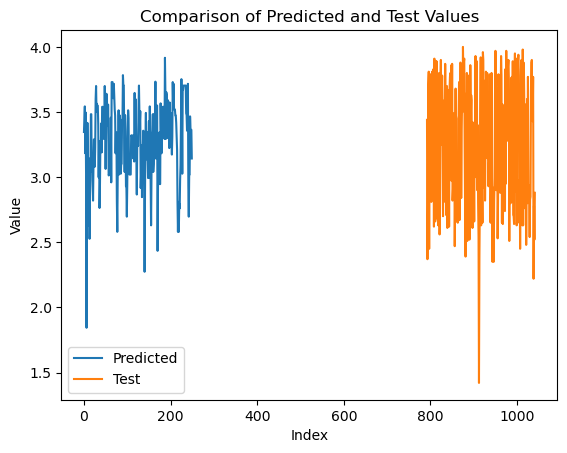

In [9]:
from sklearn.neighbors import KNeighborsRegressor

# Crear el modelo
knn = KNeighborsRegressor(n_neighbors=3)

# Ajustar el modelo a los datos de entrenamiento
knn.fit(X_train, y_train)

prediction = knn.predict(X_test)
print("Prediccion")
print(prediction)
print("Test")
print(y_test)

knn.score(X_test, y_test)
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the predicted values
ax.plot(prediction, label='Predicted')

# Plot the test values
ax.plot(y_test, label='Test')

# Set the labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Comparison of Predicted and Test Values')

# Add a legend
ax.legend()

# Show the plot
plt.show()


## Árboles de decisión

|--- feature_12 <= 0.15
|   |--- feature_12 <= -0.62
|   |   |--- value: [0.04]
|   |--- feature_12 >  -0.62
|   |   |--- value: [0.31]
|--- feature_12 >  0.15
|   |--- feature_12 <= 0.59
|   |   |--- value: [0.73]
|   |--- feature_12 >  0.59
|   |   |--- value: [0.90]



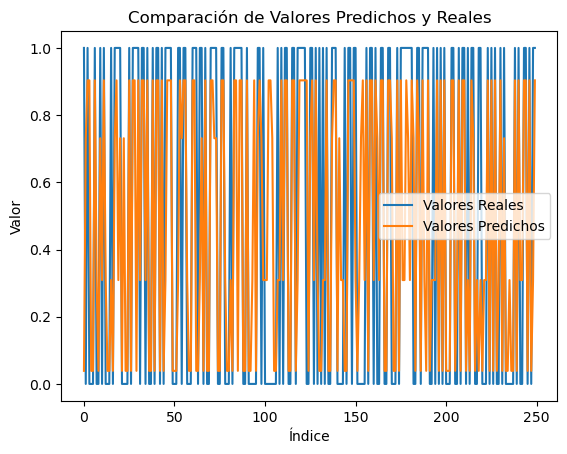

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

decision_tree = DecisionTreeRegressor(random_state=0, max_depth=2)

decision_tree = decision_tree.fit(X_train, y_train)

r = export_text(decision_tree)
print(r)
decision_tree.score(X_test, y_test)

import matplotlib.pyplot as plt

# Crear una lista con los índices de los datos de prueba
tree_prediction = decision_tree.predict(X_test)
indices = range(len(tree_prediction))

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Graficar los valores reales
ax.plot(indices, y_test, label='Valores Reales')

# Graficar los valores predichos
ax.plot(indices, tree_prediction, label='Valores Predichos')

# Configurar los ejes y la leyenda
ax.set_xlabel('Índice')
ax.set_ylabel('Valor')
ax.set_title('Comparación de Valores Predichos y Reales')
ax.legend()

# Mostrar la gráfica
plt.show()


## Red Neuronal

Lo primero que vamos a hacer con los datos es normalizarlos. Esto es necesario para que la red neuronal pueda trabajar con ellos. 

Iteration 1, loss = 0.39270818
Iteration 2, loss = 0.28569459
Iteration 3, loss = 0.20990282
Iteration 4, loss = 0.16474081
Iteration 5, loss = 0.13513173
Iteration 6, loss = 0.11651042
Iteration 7, loss = 0.10285485
Iteration 8, loss = 0.09103004
Iteration 9, loss = 0.08188940
Iteration 10, loss = 0.07527350
Iteration 11, loss = 0.07161841
Iteration 12, loss = 0.06941860
Iteration 13, loss = 0.06779120
Iteration 14, loss = 0.06635956
Iteration 15, loss = 0.06484522
Iteration 16, loss = 0.06346598
Iteration 17, loss = 0.06225112
Iteration 18, loss = 0.06105126
Iteration 19, loss = 0.05992250
Iteration 20, loss = 0.05882054
Iteration 21, loss = 0.05780885
Iteration 22, loss = 0.05689839
Iteration 23, loss = 0.05598932
Iteration 24, loss = 0.05523705
Iteration 25, loss = 0.05441777
Iteration 26, loss = 0.05371531
Iteration 27, loss = 0.05301255
Iteration 28, loss = 0.05239347
Iteration 29, loss = 0.05173407
Iteration 30, loss = 0.05109481
Iteration 31, loss = 0.05055192
Iteration 32, los

/usr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


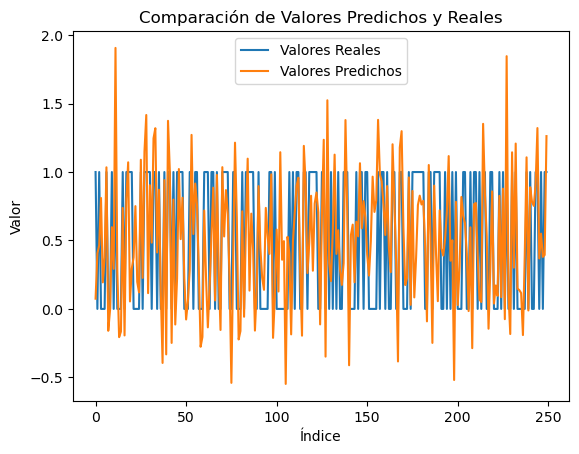

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
clf = MLPRegressor(random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)
clf.predict(X_test[:2])
y_pred = clf.predict(X_test[:, :])
print(y_test)
print(y_pred)
clf.score(X_test, y_test)

import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar los valores reales y los valores predichos
ax.plot(y_test, label='Valores Reales')
ax.plot(y_pred, label='Valores Predichos')

# Agregar etiquetas y título
ax.set_xlabel('Índice')
ax.set_ylabel('Valor')
ax.set_title('Comparación de Valores Predichos y Reales')

# Agregar una leyenda
ax.legend()

# Mostrar la gráfica
plt.show()
 

## SVM

[0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0
 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0
 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1
 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1
 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0
 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1]


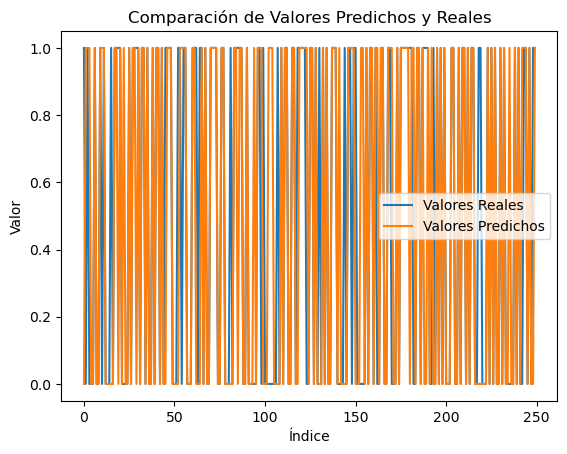

In [21]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=1)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(y_pred)
classifier.score(X_test, y_test)
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar los valores reales y los valores predichos
ax.plot(y_test, label='Valores Reales')
ax.plot(y_pred, label='Valores Predichos')

# Agregar etiquetas y título
ax.set_xlabel('Índice')
ax.set_ylabel('Valor')
ax.set_title('Comparación de Valores Predichos y Reales')

# Agregar una leyenda
ax.legend()

# Mostrar la gráfica
plt.show()
